In [1]:
import os

NUM_THREADS = "1"

os.environ["OMP_NUM_THREADS"] = NUM_THREADS
os.environ["OPENBLAS_NUM_THREADS"] = NUM_THREADS
os.environ["MKL_NUM_THREADS"] = NUM_THREADS
os.environ["VECLIB_MAXIMUM_THREADS"] = NUM_THREADS
os.environ["NUMEXPR_NUM_THREADS"] = NUM_THREADS

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
import os
from utils.RT_SHIPS_preprocess import SHIPS_train_test_split_RT, calc_d24_VMAX_rt, fore_hr_averaging, SHIPS_train_test_shuffle_CLASS_RT
from utils.RT_SHIPS_preprocess import load_processed_SHIPS, calculate_class_weights, get_RI_classes, apply_class_label_RT, get_train_test_split_RT
from utils.SHIPS_ML_model_funcs import apply_class_label, calc_CM_stats, get_scores_class_rept, get_roc_auc, get_feature_importances_RF
from utils.SHIPS_ML_model_funcs import get_confusion_matrix_RF, get_scores_best_params_RF, create_gridsearch_RF, get_train_test_split
from utils.SHIPS_ML_model_funcs import get_confusion_matrix_LR, get_scores_best_params_LR, create_gridsearch_LR, get_feature_importances_LR
from utils.SHIPS_ML_model_funcs import calc_AUPD, calculate_PD_curves
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,accuracy_score,precision_score,recall_score,classification_report
from sklearn.metrics import precision_recall_curve, auc, f1_score, fbeta_score,brier_score_loss
from sklearn.inspection import permutation_importance
import matplotlib.colors
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from utils.SHIPS_ML_model_funcs_imblearn import create_gridsearch_RF_sampler
from utils import SHIPS_plotting
import pickle

##### Model evaluation

In [3]:
def evaluate_model_RF(model,X_test,y_test,basin,fold,model_name,test_years,label_names,ncats,scoring):
    # Classification report
    report, y_true, y_pred = get_scores_best_params_RF(model,X_test,y_test,basin)
    report['Years Out'] = str(test_years)
    report['Model'] = model_name
    report['Fold'] = i
    # Confusion matrix
    cm_stats = get_confusion_matrix_RF(model,y_true,y_pred,basin,label_names,ncats)
    cm_stats['Years Out'] = str(test_years)
    cm_stats['Model'] = model_name
    cm_stats['Fold'] = i
    # Feature importances
    fi_pred = get_feature_importances_RF(model,X_test,y_test,basin,scoring)
    fi_pred['Years Out'] = str(test_years)
    fi_pred['Model'] = model_name
    fi_pred['Fold'] = i
    # ROC curve / AUC scores
    ypred_prob, p_vs_r, roc_vals, brier = get_roc_auc(X_test,basin,model,y_test,1,'R1',scoring,'equal')
    p_vs_r['Years Out'] = str(test_years)
    p_vs_r['Model'] = model_name
    p_vs_r['Fold'] = i
    roc_vals['Fold'] = i
    roc_vals['Model'] = model_name
    roc_vals['Years Out'] = str(test_years)
    brier['Years Out'] = str(test_years)
    brier['Model'] = model_name
    brier['Fold'] = i
    # Get actual predictions of target variable Y
    if basin != 'ALL':
        y_pred_all = y_test.xs(basin).copy()
    else:
        y_pred_all = y_test.copy()
    # Save predicted values of y
    y_pred_all['Y pred'] = y_pred
    y_pred_all['Y true'] = y_true
    y_pred_all['Predicted Basin'] = basin
    y_pred_all['Model'] = model_name
    # Get probabilities for 0 (not-RI) and 1 (RI)
    y_pred_all['Y pred probab (class: 0)'] = ypred_prob[:,0]
    y_pred_all['Y pred probab (class: 1)'] = ypred_prob[:,1]
    #
    return y_pred_all,roc_vals,brier,p_vs_r,fi_pred,cm_stats,report

##### Model evaluation--logistic regression

In [4]:
def evaluate_model_LR(model,X_test,y_test,basin,fold,model_name,test_years,label_names,ncats,scoring):
    # Classification report
    report, y_true, y_pred = get_scores_best_params_LR(model,X_test,y_test,basin)
    report['Years Out'] = str(test_years)
    report['Model'] = model_name
    report['Fold'] = i
    # Confusion matrix
    cm_stats = get_confusion_matrix_LR(model,y_true,y_pred,basin,label_names,ncats)
    cm_stats['Years Out'] = str(test_years)
    cm_stats['Model'] = model_name
    cm_stats['Fold'] = i
    # Feature importances
    fi_pred = get_feature_importances_LR(model,X_test,y_test,basin,scoring)
    fi_pred['Years Out'] = str(test_years)
    fi_pred['Model'] = model_name
    fi_pred['Fold'] = i
    # ROC curve / AUC scores
    ypred_prob, p_vs_r, roc_vals, brier = get_roc_auc(X_test,basin,model,y_test,1,'R1',scoring,'equal')
    p_vs_r['Years Out'] = str(test_years)
    p_vs_r['Model'] = model_name
    p_vs_r['Fold'] = i
    roc_vals['Fold'] = i
    roc_vals['Model'] = model_name
    roc_vals['Years Out'] = str(test_years)
    brier['Years Out'] = str(test_years)
    brier['Model'] = model_name
    brier['Fold'] = i
    # Get actual predictions of target variable Y
    if basin != 'ALL':
        y_pred_all = y_test.xs(basin).copy()
    else:
        y_pred_all = y_test.copy()
    # Save predicted values of y
    y_pred_all['Y pred'] = y_pred
    y_pred_all['Y true'] = y_true
    y_pred_all['Predicted Basin'] = basin
    y_pred_all['Model'] = model_name
    # Get probabilities for 0 (not-RI) and 1 (RI)
    y_pred_all['Y pred probab (class: 0)'] = ypred_prob[:,0]
    y_pred_all['Y pred probab (class: 1)'] = ypred_prob[:,1]
    #
    return y_pred_all,roc_vals,brier,p_vs_r,fi_pred,cm_stats,report

##### Load experiments

In [5]:
fpath_load = 'DATA/ML_model_results/TRAINING/all_models_ROS_and_SMOTE/'
train_yr_start = 2005
train_yr_end = 2018
mask_TYPE = 'SIMPLE'
is_stand = True
if is_stand:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'no_STANDARD'
RI_thresh = 30
wts_str = 'default'
score = 'f1_weighted'
N_samples = 25

#### Load Confusion Matrix, precision vs recall

In [6]:
path_suff = 'TRAIN_SHIPS_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_MASK_{stand_str}_RI_thresh_{RI_thresh}'\
'_{N}_samples_{scoring}.csv'.format(yr_start=train_yr_start,yr_end=train_yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,N=N_samples,scoring=score)
cm_res = pd.read_csv(fpath_load+'Conf_Matrix'+path_suff)

##### Identify best model parameters
There are a lot of ways to do this. We select the best model based on `CSI` (but you could use a different metric if you wanted, like best `PoD`, lowest `FAR`, highest `recall`, etc.).  We select the model that performs best on our all-basin predictions (but again, could make a different choice)

In [7]:
cm_max_threat = cm_res.set_index(['Category Names','BASIN','Model']).sort_values(by=['BASIN','Model','Threat'],
                                                                                ascending=[True,True,False])
basin_ALL = cm_res['BASIN'].unique().tolist()
cm_max_best = pd.DataFrame()
for ibasin in basin_ALL:
    icm = cm_max_threat.drop(columns={'Unnamed: 0','Category'}).xs(('RI',ibasin)).iloc[np.arange(0,100,25)]
    icm['BASIN'] = ibasin
    cm_max_best = cm_max_best.append(icm.reset_index(),ignore_index=True)

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


#### Load developmental SHIPS predictors for 2005-2018
SHIPS_realtime_predictors_2019-2021_ALL_basins.csv

In [8]:
def load_processed_SHIPS(yr_start,yr_end,mask_TYPE,max_fore,interp_str,use_basin='ALL'):
    SHIPS_predictors = pd.DataFrame()
    fpath_load = 'DATA/processed/'
    if use_basin == 'ALL':
        BASIN = ['ATLANTIC','EAST_PACIFIC','WEST_PACIFIC','SOUTHERN_HEM']
    else:
        BASIN = [use_basin]
    #
    for i_name in BASIN:
        fname_load = fpath_load+'SHIPS_processed_{BASIN}_set_yrs_{yr_start}-{yr_end}_max_fore_hr_{max_fore}_{interp_str}_'\
        'land_mask_{mask_TYPE}.csv'.format(BASIN=i_name,yr_start=yr_start,yr_end=yr_end,
                                          max_fore=max_fore,interp_str=interp_str,mask_TYPE=mask_TYPE)
        print(fname_load)
        iload = pd.read_csv(fname_load)
        # Change RSST / RHCN to NSST / NOHC just to keep naming consistent
        if (i_name != 'ATLANTIC') | (i_name != 'EAST_PACIFIC'):
            iload = iload.rename(columns={'RSST':'NSST','RHCN':'NOHC'})
        #
        iload['BASIN'] = i_name
        SHIPS_predictors = SHIPS_predictors.append(iload)
        #
    SHIPS_predictors = SHIPS_predictors.drop(columns={'level_0','index'})
    return SHIPS_predictors,BASIN

#### Load Realtime SHIPS predictors for 2019-2021
SHIPS_realtime_predictors_2019-2021_ALL_basins.csv

In [9]:
def load_realtime_SHIPS(yr_start,yr_end,use_basins='ALL'):
    SHIPS_predictors = pd.DataFrame()
    fpath_load = 'DATA/processed/realtime/'
    if use_basins == 'ALL':
        basin_str = 'ALL_basins'
    fname_load = fpath_load+'SHIPS_realtime_predictors_{yr_start}-{yr_end}_{basin_str}.csv'.format(yr_start=yr_start,
                                                                    yr_end=yr_end,basin_str=basin_str)
    iload = pd.read_csv(fname_load)
    SHIPS_predictors = iload.drop(columns={'level_0','index','Unnamed: 0'})
    return SHIPS_predictors

In [10]:
yr_start = 2019
yr_end = 2021
SHIPS_rt = load_realtime_SHIPS(yr_start,yr_end)
SHIPS_rt['BASIN'] = SHIPS_rt['BASIN'].replace({'CENTRAL_PACIFIC':'EAST_PACIFIC'})


In [25]:
cm_max_sel = cm_max_best.set_index(['BASIN','Model']).xs('ALL')
C_vals = [cm_max_sel.xs('Logistic Reg.')['C']]
max_iter = [cm_max_sel.xs('Logistic Reg.')['Max Iter'].astype(int)]
#
cw_max_depth = [cm_max_sel.xs('Random Forest (class wt)')['Max Depth'].astype(int)]
cw_max_feat = [cm_max_sel.xs('Random Forest (class wt)')['Max Features'].astype(int)]
cw_n_est = [cm_max_sel.xs('Random Forest (class wt)')['N Estimators'].astype(int)]
cw_min_samp_leaf = [cm_max_sel.xs('Random Forest (class wt)')['Min Samples Leaf'].astype(int)]
#
smote_max_depth = [cm_max_sel.xs('Random Forest (SMOTE)')['Max Depth'].astype(int)]
smote_max_feat = [cm_max_sel.xs('Random Forest (SMOTE)')['Max Features'].astype(int)]
smote_n_est = [cm_max_sel.xs('Random Forest (SMOTE)')['N Estimators'].astype(int)]
smote_min_samp_leaf = [cm_max_sel.xs('Random Forest (SMOTE)')['Min Samples Leaf'].astype(int)]
#
ov_max_depth = [cm_max_sel.xs('Random Forest (random oversample)')['Max Depth'].astype(int)]
ov_max_feat = [cm_max_sel.xs('Random Forest (random oversample)')['Max Features'].astype(int)]
ov_n_est = [cm_max_sel.xs('Random Forest (random oversample)')['N Estimators'].astype(int)]
ov_min_samp_leaf = [cm_max_sel.xs('Random Forest (random oversample)')['Min Samples Leaf'].astype(int)]


In [13]:
hrs_max = 24
# Features to drop before ML model
drop_features = {'VMAX','DELV','VMPI','GOES Tb','s(GOES Tb)','storm size','pct < -50C','PC1',
                'PC2','PC3','PC4'}
to_IND = ['BASIN','ATCFID','CASE','DATE_full','TIME']
RI_thresh = 30
is_RI_only = True
n_classes = 2
is_standard = True
if is_standard == True:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'noSTANDARDIZED'
DO_AVG = True
# Cross-val
k_folds = 10
n_repeats = 3
fig_format = 'png'
#
# Logistic
solver = 'lbfgs'
if (solver == 'saga'):
    penalty = 'l1'
else: 
    penalty = 'l2'

In [14]:
ncats = 2
to_predict = 'I_class'
scoring = 'f1_weighted'
cut = 'equal'
sampler = SMOTE(sampling_strategy = 0.9)
sampler_str = 'over'
sampler2 = [RandomOverSampler(sampling_strategy = 0.9)]
sampler_str2 = ['over']
sampler_str_ALL = [sampler_str]#,sampler_str2]
sampler_ALL = [sampler]#,sampler2]
#
# FULL_yrs = np.arange(yr_start,yr_end_TRAIN,1)
use_custom_wts = False
wts_sel = 0
n_valid = 3
score = ['gini']
label_names = ['not RI','RI']
basin_ALL = ['ATLANTIC', 'EAST_PACIFIC', 'WEST_PACIFIC', 'SOUTHERN_HEM','ALL']
# Loop through bootstrapping examples

In [15]:
predicted_y_ALL = pd.DataFrame()
roc_vals_ALL = pd.DataFrame()
brier_loss_ALL = pd.DataFrame()
p_vs_r_ALL = pd.DataFrame()
fi_pred_ALL = pd.DataFrame()
fi_pred_train_ALL = pd.DataFrame()
cm_ALL = pd.DataFrame()
report_ALL = pd.DataFrame()

In [16]:
# Split data into training/validation
test_years = [2019,2020,2021] # years we will use for validation
diff_testx = calc_d24_VMAX_rt(SHIPS_rt.reset_index(),0)
diff_test = get_RI_classes(diff_testx,is_RI_only,n_classes,RI_thresh)
diff_test = diff_test.rename(columns={'VMAX':'d24_VMAX'}).reset_index().set_index(to_IND)
predict_test = diff_test[[to_predict]]
SHIPS_test = SHIPS_rt[SHIPS_rt['TIME'].isin(np.arange(0,hrs_max+1))]
SHIPS_test = SHIPS_test.set_index(['BASIN','CASE','TIME'])
SHIPS_test_all = SHIPS_test.reset_index().set_index(to_IND).join(predict_test.reset_index().set_index(to_IND)).reset_index().set_index(to_IND)


def calc_d24_VMAX_rt(SHIPS,init_hr):
    SHIPS_t0 = SHIPS.set_index(['ATCFID','TIME']).xs(0,level=1).sort_values(by='DATE_full')
    SHIPS_t24 = SHIPS_t0.shift(-4)
    pred_num = ['VMAX']
    date_diff = pd.to_datetime(SHIPS_t24['DATE_full']) - pd.to_datetime(SHIPS_t0['DATE_full'])
    diffs = SHIPS_t24[pred_num] - SHIPS_t0[pred_num]
    diffs['DATE_full'] = SHIPS_t0['DATE_full']
    diff_train = diffs.where(date_diff == pd.Timedelta(1,'D'))
    # diff_train = diff_train.rename(columns={'VMAX':'d24_VMAX','MSLP':'d24_MSLP'})
    return diff_train

In [17]:
y_test_f = SHIPS_test_all[[to_predict]].dropna(how='all')
SHIPS_test_d = SHIPS_test_all.drop(columns=drop_features)
X_test = SHIPS_test_d.drop([24.0],axis=0,level=4)
X_test_full = X_test.mean(level=['BASIN','CASE','ATCFID','DATE_full'])
y_test = y_test_f.mean(level=['BASIN','CASE','ATCFID','DATE_full'])
X_test_trim = X_test_full.loc[y_test.index.values]
X_test_trim = X_test_trim.drop(columns={'MSLP','I_class'})
X_test_trim = X_test_trim.dropna(how='any')
y_test_rt = y_test.loc[X_test_trim.index.values]

In [18]:
X_test_rt = X_test_trim.reindex(np.random.permutation(X_test_trim.index))
y_test_rt = y_test.reindex(X_test_rt.index)
X_test_rt

DTL    SHRG          D200  \
BASIN        CASE ATCFID   DATE_full                                            
EAST_PACIFIC 3370 EP212020 2020-11-18 18:00:00  1096.50  27.325 -1.825000e-06   
SOUTHERN_HEM 1820 SH172019 2019-03-03 00:00:00  2508.25  26.625  5.850000e-06   
             8165 SH012022 2021-11-23 00:00:00   722.00  17.850  4.325000e-06   
EAST_PACIFIC 8161 EP062021 2021-07-17 12:00:00  1783.25  13.300 -2.325000e-06   
WEST_PACIFIC 7852 WP162021 2021-08-22 06:00:00   345.25  48.925  1.775000e-06   
...                                                 ...     ...           ...   
EAST_PACIFIC 3178 EP072020 2020-07-21 06:00:00  2049.50  16.225  2.500000e-07   
ATLANTIC     9843 AL032021 2021-06-21 18:00:00   266.00  17.100  3.350000e-06   
WEST_PACIFIC 9737 WP022021 2021-04-16 12:00:00   595.75  25.625  1.280000e-05   
ATLANTIC     624  AL102019 2019-09-24 00:00:00   943.00  29.050  2.700000e-06   
SOUTHERN_HEM 1167 SH192019 2019-03-20 00:00:00  2691.25  47.275  3.325000e-06   

                                                        Z850   RHMD    NSST  \
BASIN        CASE ATCFID   DATE_full                                          
EAST_PACIFIC 3370 EP212020 2020-11-18 18:00:00 -3.400000e-06  50.50  26.775   
SOUTHERN_HEM 1820 SH172019 2019-03-03 00:00:00 -1.755000e-05  77.50  29.100   
             8165 SH012022 2021-11-23 00:00:00 -7.200000e-06  63.75  26.600   
EAST_PACIFIC 8161 EP062021 2021-07-17 12:00:00  1.250000e-07  47.25  26.775   
WEST_PACIFIC 7852 WP162021 2021-08-22 06:00:00 -4.625000e-06  59.75  28.750   
...                                                      ...    ...     ...   
EAST_PACIFIC 3178 EP072020 2020-07-21 06:00:00 -3.250000e-06  54.50  24.575   
ATLANTIC     9843 AL032021 2021-06-21 18:00:00 -8.500000e-07  61.25  21.475   
WEST_PACIFIC 9737 WP022021 2021-04-16 12:00:00  1.517500e-05  74.25  29.350   
ATLANTIC     624  AL102019 2019-09-24 00:00:00  2.500000e-08  57.50  27.175   
SOUTHERN_HEM 1167 SH192019 2019-03-20 00:00:00 -7.675000e-06  55.50  27.125   

                                                 NOHC  DELV -12    POT  
BASIN        CASE ATCFID   DATE_full                                    
EAST_PACIFIC 3370 EP212020 2020-11-18 18:00:00   2.00       5.0  98.50  
SOUTHERN_HEM 1820 SH172019 2019-03-03 00:00:00  51.25      15.0  98.25  
             8165 SH012022 2021-11-23 00:00:00   9.75       0.0  38.25  
EAST_PACIFIC 8161 EP062021 2021-07-17 12:00:00   2.50      10.0 -35.75  
WEST_PACIFIC 7852 WP162021 2021-08-22 06:00:00  25.25     -15.0  80.00  
...                                               ...       ...    ...  
EAST_PACIFIC 3178 EP072020 2020-07-21 06:00:00   0.00       0.0  -2.50  
ATLANTIC     9843 AL032021 2021-06-21 18:00:00   0.00       5.0 -35.00  
WEST_PACIFIC 9737 WP022021 2021-04-16 12:00:00  40.25      15.0  63.25  
ATLANTIC     624  AL102019 2019-09-24 00:00:00   9.75       0.0  77.75  
SOUTHERN_HEM 1167 SH192019 2019-03-20 00:00:00  12.50       0.0  78.75  

[3782 rows x 9 columns]

In [19]:
##X_test_trim = X_test_full.loc[y_test.index.values]
#X_test_trim = X_test_trim.drop(columns={'MSLP','I_class'})
X_test_full.reset_index()['BASIN'].unique()
y_test = y_test_f.mean(level=['BASIN','CASE','ATCFID','DATE_full'])
y_test.reset_index()['BASIN'].unique()
X_test_trim = X_test_full.loc[y_test.index.values]
X_test_trim = X_test_trim.drop(columns={'MSLP','I_class'})


Use normal SHIPS data for training

In [20]:
max_fore = 24 # maximum forecast hours
mask_TYPE = 'SIMPLE_MASK' # how are we handling the land mask?
interp_str = 'INTERP' # did we interpolate?
yr_start = 2005
yr_start_TEST = 2019
yr_end_LOAD = 2021
yr_end_TRAIN = 2018
use_basin = 'ALL'

SHIPS_predictors_reg,BASIN = load_processed_SHIPS(yr_start,yr_end_LOAD,mask_TYPE,max_fore,interp_str,use_basin)
#
FULL_yrs = np.arange(yr_start,yr_end_LOAD+1,1)
SHIPS_predictors_DEV = SHIPS_predictors_reg[pd.to_datetime(SHIPS_predictors_reg['DATE_full']).dt.year.isin(FULL_yrs)]

DATA/processed/SHIPS_processed_ATLANTIC_set_yrs_2005-2021_max_fore_hr_24_INTERP_land_mask_SIMPLE_MASK.csv
DATA/processed/SHIPS_processed_EAST_PACIFIC_set_yrs_2005-2021_max_fore_hr_24_INTERP_land_mask_SIMPLE_MASK.csv
DATA/processed/SHIPS_processed_WEST_PACIFIC_set_yrs_2005-2021_max_fore_hr_24_INTERP_land_mask_SIMPLE_MASK.csv
DATA/processed/SHIPS_processed_SOUTHERN_HEM_set_yrs_2005-2021_max_fore_hr_24_INTERP_land_mask_SIMPLE_MASK.csv


In [21]:
test_years = [2019,2020,2021] # years we will use for validation
to_IND = ['BASIN','ATCFID','CASE','NAME','DATE_full','TIME']
X_train, fX_test, y_train, fy_test, f_feature_names, f_diff_train, f_diff_test = get_train_test_split(test_years,SHIPS_predictors_DEV,to_predict,
                                                                is_RI_only,to_IND,drop_features,DO_AVG,RI_thresh,hrs_max)


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_preprocess.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_preprocess.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SHIPS_t0['DATE_full'] = pd.to_datetime(SHIPS_t0['DATE_full'])


averaging hours together


In [23]:
X_train_use = X_train[X_test_trim.columns]
#feature_names_rt
X_train_use

DTL    SHRG  \
BASIN        ATCFID   CASE    NAME DATE_full                                  
ATLANTIC     AL132011 9621.0  LEE  2011-09-02 12:00:00   175.333333  23.800   
EAST_PACIFIC EP062015 13981.0 ENRI 2015-07-16 06:00:00  2044.500000  20.050   
SOUTHERN_HEM SH042006 6028.0  SH04 2005-12-27 06:00:00  1191.500000  12.250   
             SH112018 13139.0 SH11 2018-03-02 18:00:00   387.500000  15.650   
WEST_PACIFIC WP222014 18783.0 WP22 2014-12-01 00:00:00  1261.250000  16.175   
...                                                             ...     ...   
             WP142017 20475.0 WP14 2017-08-16 00:00:00  1961.750000  25.850   
ATLANTIC     AL152017 11659.0 MARI 2017-09-17 12:00:00   557.250000  18.600   
WEST_PACIFIC WP022015 18875.0 WP02 2015-02-10 00:00:00  2303.000000  37.800   
ATLANTIC     AL042018 11848.0 DEBB 2018-08-08 06:00:00   745.250000  16.900   
WEST_PACIFIC WP052005 13381.0 WP05 2005-07-15 06:00:00  1070.750000  20.975   

                                                                D200  \
BASIN        ATCFID   CASE    NAME DATE_full                           
ATLANTIC     AL132011 9621.0  LEE  2011-09-02 12:00:00  7.966667e-06   
EAST_PACIFIC EP062015 13981.0 ENRI 2015-07-16 06:00:00  1.900000e-06   
SOUTHERN_HEM SH042006 6028.0  SH04 2005-12-27 06:00:00  3.500000e-06   
             SH112018 13139.0 SH11 2018-03-02 18:00:00  1.387500e-05   
WEST_PACIFIC WP222014 18783.0 WP22 2014-12-01 00:00:00  1.087500e-05   
...                                                              ...   
             WP142017 20475.0 WP14 2017-08-16 00:00:00  6.550000e-06   
ATLANTIC     AL152017 11659.0 MARI 2017-09-17 12:00:00  5.925000e-06   
WEST_PACIFIC WP022015 18875.0 WP02 2015-02-10 00:00:00  2.250000e-06   
ATLANTIC     AL042018 11848.0 DEBB 2018-08-08 06:00:00  5.000000e-07   
WEST_PACIFIC WP052005 13381.0 WP05 2005-07-15 06:00:00  4.500000e-06   

                                                                Z850  \
BASIN        ATCFID   CASE    NAME DATE_full                           
ATLANTIC     AL132011 9621.0  LEE  2011-09-02 12:00:00  2.333333e-07   
EAST_PACIFIC EP062015 13981.0 ENRI 2015-07-16 06:00:00  6.350000e-06   
SOUTHERN_HEM SH042006 6028.0  SH04 2005-12-27 06:00:00  8.550000e-06   
             SH112018 13139.0 SH11 2018-03-02 18:00:00  9.875000e-06   
WEST_PACIFIC WP222014 18783.0 WP22 2014-12-01 00:00:00  7.300000e-06   
...                                                              ...   
             WP142017 20475.0 WP14 2017-08-16 00:00:00  1.000000e-06   
ATLANTIC     AL152017 11659.0 MARI 2017-09-17 12:00:00  1.175000e-06   
WEST_PACIFIC WP022015 18875.0 WP02 2015-02-10 00:00:00  7.375000e-06   
ATLANTIC     AL042018 11848.0 DEBB 2018-08-08 06:00:00  3.250000e-07   
WEST_PACIFIC WP052005 13381.0 WP05 2005-07-15 06:00:00  1.390000e-05   

                                                             RHMD       NSST  \
BASIN        ATCFID   CASE    NAME DATE_full                                   
ATLANTIC     AL132011 9621.0  LEE  2011-09-02 12:00:00  60.666667  30.833333   
EAST_PACIFIC EP062015 13981.0 ENRI 2015-07-16 06:00:00  49.250000  24.975000   
SOUTHERN_HEM SH042006 6028.0  SH04 2005-12-27 06:00:00  63.000000  27.075000   
             SH112018 13139.0 SH11 2018-03-02 18:00:00  83.500000  30.225000   
WEST_PACIFIC WP222014 18783.0 WP22 2014-12-01 00:00:00  76.500000  29.875000   
...                                                           ...        ...   
             WP142017 20475.0 WP14 2017-08-16 00:00:00  68.000000  24.875000   
ATLANTIC     AL152017 11659.0 MARI 2017-09-17 12:00:00  61.500000  29.075000   
WEST_PACIFIC WP022015 18875.0 WP02 2015-02-10 00:00:00  44.750000  27.600000   
ATLANTIC     AL042018 11848.0 DEBB 2018-08-08 06:00:00  56.000000  25.625000   
WEST_PACIFIC WP052005 13381.0 WP05 2005-07-15 06:00:00  66.250000  29.850000   

                                                         NOHC  DELV -12  \
BASIN        ATCFID   CASE    NAME DATE_full  

In [26]:
# Set up hyperparameter sweeps
RF_model_ov = create_gridsearch_RF_sampler(is_standard,score,smote_max_depth,smote_n_est,smote_max_feat,smote_min_samp_leaf,
                            k_folds,n_repeats,scoring,sampler_ALL,sampler_str_ALL)
#
RF_model_ROS = create_gridsearch_RF_sampler(is_standard,score,ov_max_depth,ov_n_est,ov_max_feat,ov_min_samp_leaf,
                            k_folds,n_repeats,scoring,sampler2,sampler_str2)
#
RF_model = create_gridsearch_RF(is_standard,score,cw_max_depth,cw_n_est,cw_max_feat,cw_min_samp_leaf,
                            k_folds,n_repeats,use_custom_wts,wts_sel,scoring)
# 
LR_model = create_gridsearch_LR(is_standard,solver,penalty,C_vals,max_iter,k_folds,n_repeats,
                                use_custom_wts,wts_sel,scoring,no_wts=False)
#
print('fitting models')
LR_model.fit(X_train_use,y_train['I_class'])
RF_model.fit(X_train_use,y_train['I_class'])
RF_model_ov.fit(X_train_use,y_train['I_class'])
RF_model_ROS.fit(X_train_use,y_train['I_class'])

fitting models


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('over',
                                        RandomOverSampler(sampling_strategy=0.9)),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'clf__criterion': ['gini'], 'clf__max_depth': [11],
                         'clf__max_features': [5],
                         'clf__min_samples_leaf': [10],
                         'clf__n_estimators': [250]},
             scoring='f1_weighted')

In [27]:
#X_test = X_test.drop(columns={'MSLP'})
#X_test['TYPE'] = 1
X_test = X_test_rt[X_train_use.columns]
#X_test = X_test.mask(X_test==999).dropna(how='any')
y_test = y_test_rt.loc[X_test.index]

In [30]:
X_test.reset_index().groupby(['BASIN','ATCFID']).count()
#X_test_rt.isna().sum()
y_test.groupby(['BASIN','ATCFID']).count()

I_class
BASIN        ATCFID           
ATLANTIC     AL012019        4
             AL012020       12
             AL012021        8
             AL022019        9
             AL022021        7
...                        ...
WEST_PACIFIC WP272021       12
             WP282019        2
             WP282021        7
             WP292019       19
             WP302019        8

[280 rows x 1 columns]

In [31]:
y_test_rt.reset_index()['BASIN'].unique()#.set_index(['ATCFID'])#.xs('WP192021').sort_values(by='DATE_full')#.iloc[40:60]

array(['EAST_PACIFIC', 'SOUTHERN_HEM', 'WEST_PACIFIC', 'ATLANTIC'],
      dtype=object)

In [32]:
SHIPS_rt.set_index(['ATCFID','TIME']).xs(('AL182021',0)).sort_values(by='DATE_full')#.plot(y='VMAX')

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


CASE            DATE_full   VMAX  MSLP     DTL  SHRG  \
ATCFID   TIME                                                         
AL182021 0.0   9306  2021-09-23 00:00:00   30.0   NaN  1583.0  12.7   
         0.0   9688  2021-09-23 06:00:00   30.0   NaN  1553.0  11.9   
         0.0   8061  2021-09-23 12:00:00   40.0   NaN  1549.0   9.2   
         0.0   8139  2021-09-23 18:00:00   50.0   NaN  1530.0   9.0   
         0.0   9179  2021-09-24 00:00:00   60.0   NaN  1431.0   8.6   
         0.0   7482  2021-09-24 06:00:00   65.0   NaN  1336.0  10.8   
         0.0   9042  2021-09-24 12:00:00   65.0   NaN  1228.0  11.9   
         0.0   7076  2021-09-24 18:00:00   70.0   NaN  1164.0  12.4   
         0.0   9178  2021-09-25 00:00:00   85.0   NaN  1124.0  12.6   
         0.0   8193  2021-09-25 06:00:00   95.0   NaN  1099.0  14.7   
         0.0   7806  2021-09-25 12:00:00  105.0   NaN  1047.0  13.9   
         0.0   6733  2021-09-25 18:00:00  115.0   NaN  1022.0  11.9   
         0.0   8689  2021-09-26 00:00:00  125.0   NaN  1021.0  10.6   
         0.0   8327  2021-09-26 06:00:00  125.0   NaN  1019.0  13.6   
         0.0   8473  2021-09-26 12:00:00  125.0   NaN  1001.0  12.4   
         0.0   9445  2021-09-26 18:00:00  130.0   NaN  1007.0  10.4   
         0.0   8035  2021-09-27 00:00:00  130.0   NaN  1046.0  13.8   
         0.0   7146  2021-09-27 06:00:00  120.0   NaN  1081.0  15.4   
         0.0   9414  2021-09-27 12:00:00  110.0   NaN  1107.0  13.3   
         0.0   7670  2021-09-27 18:00:00  105.0   NaN  1095.0  10.9   
         0.0   8409  2021-09-28 00:00:00  105.0   NaN  1080.0  13.8   
         0.0   9057  2021-09-28 06:00:00  115.0   NaN  1054.0  18.8   
         0.0   7109  2021-09-28 12:00:00  115.0   NaN  1044.0  20.0   
         0.0   9781  2021-09-28 18:00:00  115.0   NaN  1024.0  18.2   
         0.0   8639  2021-09-29 00:00:00  120.0   NaN  1017.0  17.7   
         0.0   7747  2021-09-29 06:00:00  115.0   NaN  1025.0  19.5   
         0.0   9622  2021-09-29 12:00:00  115.0   NaN   962.0  19.4   
         0.0   9409  2021-09-29 18:00:00  115.0   NaN   898.0  15.7   
         0.0   7915  2021-09-30 00:00:00  125.0   NaN   838.0  17.4   
         0.0   8128  2021-09-30 06:00:00  125.0   NaN   782.0  21.0   
         0.0   7851  2021-09-30 12:00:00  125.0   NaN   772.0  19.9   
         0.0   7515  2021-09-30 18:00:00  125.0   NaN   759.0  19.0   
         0.0   6896  2021-10-01 00:00:00  125.0   NaN   825.0  21.0   
         0.0   9575  2021-10-01 06:00:00  130.0   NaN   929.0  22.1   
         0.0   6965  2021-10-01 12:00:00  130.0   NaN  1103.0  17.6   
         0.0   9771  2021-10-01 18:00:00  130.0   NaN  1260.0  21.7   
         0.0   9003  2021-10-02 00:00:00  125.0   NaN  1430.0  28.0   
         0.0   7047  2021-10-02 06:00:00  115.0   NaN  1327.0  31.1   
         0.0   6878  2021-10-02 12:00:00  115.0   NaN  1237.0  26.0   
         0.0   7392  2021-10-02 18:00:00  110.0   NaN  1130.0  25.1   
         0.0   6926  2021-10-03 00:00:00  105.0   NaN  1075.0  22.9   
         0.0   8336  2021-10-03 06:00:00   90.0   NaN  1010.0  15.6   
         0.0   8990  2021-10-03 12:00:00   85.0   NaN  1003.0  14.7   
         0.0   6677  2021-10-03 18:00:00   85.0   NaN   967.0  19.2   
         0.0   8177  2021-10-04 00:00:00   90.0   NaN   892.0  23.9   
         0.0   7342  2021-10-04 06:00:00   90.0   NaN   799.0  26.0   
         0.0   8819  2021-10-04 12:00:00   85.0   NaN   759.0  33.7   
         0.0   7941  2021-10-04 18:00:00   80.0   NaN   810.0  38.1   
         0.0   8143  2021-10-05 00:00:00   75.0   NaN   930.0  43.5   
         0.0   7467  2021-10-05 06:00:00   70.0   NaN  1005.0  49.4   

                       D200          Z850   VMPI  DELV  ...    POT     BASIN  \
ATCFID   TIME                                           ...                    
AL182021 0.0   1.700000e-06  1.400000e-06  151.0   0.0  ...  121.0  ATLANTIC   
         0.0  -9.000000e-07  1.500000e-06  148.0   0.0  ...  118.0  ATLANTIC   
  

In [33]:
i = 0
for basin in basin_ALL:
    print(basin)
    y_pred_all_RF_OV,roc_vals_RF_OV,brier_loss_OV,p_vs_r_RF_OV,fi_pred_RF_OV,cm_stats_RF_OV,report_RF_OV = evaluate_model_RF(RF_model_ov,
                          X_test,y_test,basin,i,'Random Forest (SMOTE)',test_years,label_names,ncats,scoring)
    # 
    y_pred_all_ROS,roc_vals_ROS,brier_loss_ROS,p_vs_r_ROS,fi_pred_ROS,cm_stats_ROS,report_ROS = evaluate_model_RF(RF_model_ROS,
                          X_test,y_test,basin,i,'Random Forest (random oversample)',test_years,label_names,ncats,scoring)
    #
    y_pred_all_RF,roc_vals_RF,brier_loss_RF,p_vs_r_RF,fi_pred_RF,cm_stats_RF,report_RF = evaluate_model_RF(RF_model,
                          X_test,y_test,basin,i,'Random Forest (class wt)',test_years,label_names,ncats,scoring)
    # 
    y_pred_all_LR,roc_vals_LR,brier_loss_LR,p_vs_r_LR,fi_pred_LR,cm_stats_LR,report_LR = evaluate_model_LR(LR_model,
                          X_test,y_test,basin,i,'Logistic Reg.',test_years,label_names,ncats,scoring)
    # 
    y_pred_all = pd.concat([y_pred_all_RF_OV,y_pred_all_ROS,y_pred_all_RF,y_pred_all_LR])
    predicted_y_ALL = predicted_y_ALL.append(y_pred_all)
    # 
    roc_vals = pd.concat([roc_vals_RF,roc_vals_ROS,roc_vals_RF_OV,roc_vals_LR])
    roc_vals_ALL = roc_vals_ALL.append(roc_vals)
    #
    brier_loss_vals = pd.concat([brier_loss_RF,brier_loss_ROS,brier_loss_OV,brier_loss_LR])
    brier_loss_ALL = brier_loss_ALL.append(brier_loss_vals)
    #
    pvr = pd.concat([p_vs_r_RF_OV,p_vs_r_ROS,p_vs_r_RF,p_vs_r_LR])
    p_vs_r_ALL = p_vs_r_ALL.append(pvr)
    # 
    fi_pred = pd.concat([fi_pred_RF_OV,fi_pred_ROS,fi_pred_RF,fi_pred_LR])
    fi_pred_ALL = fi_pred_ALL.append(fi_pred)
    #
    cm_stats = pd.concat([cm_stats_RF_OV,cm_stats_ROS,cm_stats_RF,cm_stats_LR])
    cm_ALL = cm_ALL.append(cm_stats)
    #
    report = pd.concat([report_RF_OV,report_ROS,report_RF,report_LR])
    report_ALL = report_ALL.append(report)

ATLANTIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


EAST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


WEST_PACIFIC


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


SOUTHERN_HEM


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


ALL


/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_ML_model_funcs.py:378: RuntimeWarning: invalid value encountered in true_divide
  f1 = (2*p*r)/(p+r)


<AxesSubplot:xlabel='BASIN', ylabel='Threat'>

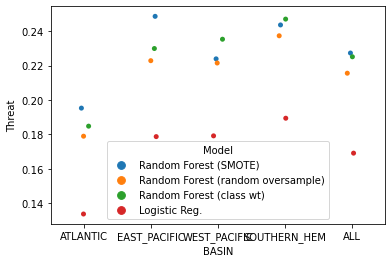

In [34]:
sns.stripplot(data=cm_ALL.set_index(['Category Names','BASIN','Model']).xs('RI').reset_index(),
            x='BASIN',y='Threat',hue='Model')

In [35]:
save_dir = 'DATA/ML_model_results/TESTING/REALTIME/'
model_type = 'all_models_ROS_and_SMOTE'
save_dir = save_dir+model_type+'/'
save_extension = 'TEST_SHIPS_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'_{scoring}.csv'.format(yr_start=yr_start_TEST,yr_end=yr_end_LOAD,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,scoring=scoring)
save_ext_figs = 'TEST_SHIPS_SIMPLE_RI_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_{stand_str}_RI_thresh_{RI_thresh}'\
'_{scoring}.png'.format(yr_start=yr_start_TEST,yr_end=yr_end_LOAD,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,scoring=scoring)

##### Create subdirectories if they don't exist

In [36]:
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
# figs directory
if not os.path.exists(save_dir+'/figs/'):
    os.makedirs(save_dir+'/figs/')

In [37]:
predicted_y_ALL.to_csv(save_dir+'PREDICTED_Y_vals'+save_extension)
print('saved y vals')
roc_vals_ALL.to_csv(save_dir+'ROC_AUC_vals'+save_extension)
print('saved ROC vals')
p_vs_r_ALL.to_csv(save_dir+'Prec_vs_recall'+save_extension)
print('saved precision / recall values')
fi_pred_ALL.to_csv(save_dir+'Feat_Imp_validation'+save_extension)
print('saved feat importances')
fi_pred_train_ALL.to_csv(save_dir+'Feat_Imp_TRAIN'+save_extension)
print('saved feat importances (training)')
cm_ALL.to_csv(save_dir+'Conf_Matrix'+save_extension)
print('saved confusion matrix')
report_ALL.to_csv(save_dir+'Class_Report'+save_extension)
print('saved classification report ',save_dir+'Class_Report'+save_extension)

saved y vals
saved ROC vals
saved precision / recall values
saved feat importances
saved feat importances (training)
saved confusion matrix
saved classification report  DATA/ML_model_results/TESTING/REALTIME/all_models_ROS_and_SMOTE/Class_ReportTEST_SHIPS_vs_no_RI_2019-2021_SIMPLE_MASK_STANDARDIZED_RI_thresh_30_f1_weighted.csv


In [ ]:
#X_test_rt.isna().sum()

In [ ]:
X_test.reset_index().groupby(['BASIN']).count()

In [ ]:
y_test.reset_index().groupby(['BASIN','I_class label']).count()